# Data Load

In [1]:
from utils import seed

seed.seed_everything()

In [2]:
from data import dataset

import numpy as np
import matplotlib.pyplot as plt

In [14]:
# download path or (already downloaded) dataset path 
path = './data/data'

train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=224,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=32, 
                                                          download=False,
                                                          seed=21)

torch.Size([32, 3, 224, 224])


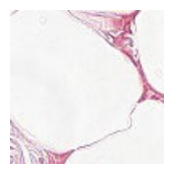

In [15]:
images, labels = next(iter(train_loader))
print(images.size())

oneshot = images[0].permute(1,2,0).numpy()
plt.figure(figsize=(2,2))
plt.imshow(oneshot)
plt.axis("off")
plt.show()

In [16]:
labels.size(), labels.dtype

(torch.Size([32]), torch.int64)

# Modeling

In [6]:
from model.backbone import VGG16, ResNet34
from model.basic_classifier import BasicClassifier

import torch

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
backbone = VGG16.VGG16_Backbone().to(device=device)
model = BasicClassifier(backbone=backbone, num_classes=1).to(device=device)

# print(model)

# Model Train

In [9]:
from utils.train import *

import torch
import torch.nn as nn
import torch.optim as optim

In [10]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-3, weight_decay=1e-3, momentum=0.9)
es = EarlyStopping(patience=10, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)

In [11]:
history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
EPOCHS = 30
max_loss = np.inf    

In [ ]:
for epoch in range(EPOCHS):
    train_loss, train_acc = model_train(model=model, 
                                        data_loader=train_loader, 
                                        criterion=criterion, 
                                        optimizer=optimizer, 
                                        device=device, 
                                        scheduler=scheduler, 
                                        tqdm_disable=False)
    val_loss, val_acc = model_evaluate(model=model, 
                                       data_loader=val_loader, 
                                       criterion=criterion, 
                                       device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_acc)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')